In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind, shapiro, wilcoxon, chi2_contingency
import networkx as nx

# objective

Analyze data from date 1-3 and 8-10 to determine if there is any significant different between new year and normal weekend

In [2]:
def describe_data(df: pd.DataFrame) -> pd.DataFrame:
    DataDict = pd.DataFrame(df.dtypes)
    DataDict['Miss'] = df.isnull().sum()
    DataDict['Unique'] = df.nunique()
    DataDict['Count'] = df.count()
    DataDict['Total'] = DataDict['Count'] + DataDict['Miss']
    return DataDict  

In [3]:
data = pd.read_parquet('yellow_tripdata_2021-01.parquet')
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,NaN,8.89,NaN,None,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,NaN,NaN
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,NaN,7.43,NaN,None,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,NaN,NaN
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,NaN,6.26,NaN,None,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,NaN,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,None,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,NaN,NaN


In [4]:
location = pd.read_csv('taxi+_zone_lookup.csv')
(location['LocationID'] == range(1,266)).value_counts()

True    265
Name: LocationID, dtype: int64

location id from 1 to 265

In [5]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,int64,0,3,1369769,1369769
tpep_pickup_datetime,datetime64[ns],0,939020,1369769,1369769
tpep_dropoff_datetime,datetime64[ns],0,935992,1369769,1369769
passenger_count,float64,98352,9,1271417,1369769
trip_distance,float64,0,3787,1369769,1369769
RatecodeID,float64,98352,7,1271417,1369769
store_and_fwd_flag,object,98352,2,1271417,1369769
PULocationID,int64,0,258,1369769,1369769
DOLocationID,int64,0,260,1369769,1369769
payment_type,int64,0,5,1369769,1369769


In [6]:
data['VendorID'] = data['VendorID'].astype('category')
data['RatecodeID'] = data['RatecodeID'].astype('category')
data['PULocationID'] = data['PULocationID'].astype('category')
data['DOLocationID'] = data['DOLocationID'].astype('category')
data['payment_type'] = data['payment_type'].astype('category')
data = pd.concat([data, pd.get_dummies(data['store_and_fwd_flag'], prefix='store_fwd_')],axis=1 )
# data = data.drop('store_and_fwd_flag',axis=1)
data['store_fwd__N'] = data['store_fwd__N'].astype('boolean')
data['store_fwd__Y'] = data['store_fwd__Y'].astype('boolean')

In [7]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,3,1369769,1369769
tpep_pickup_datetime,datetime64[ns],0,939020,1369769,1369769
tpep_dropoff_datetime,datetime64[ns],0,935992,1369769,1369769
passenger_count,float64,98352,9,1271417,1369769
trip_distance,float64,0,3787,1369769,1369769
RatecodeID,category,98352,7,1271417,1369769
store_and_fwd_flag,object,98352,2,1271417,1369769
PULocationID,category,0,258,1369769,1369769
DOLocationID,category,0,260,1369769,1369769
payment_type,category,0,5,1369769,1369769


In [8]:
data.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,store_fwd__N,store_fwd__Y
count,1.271417e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.271417e+06,5.0,1369769,1369769
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1252433,1350785
mean,1.411508e+00,4.631983e+00,1.209663e+01,9.705133e-01,4.930412e-01,1.918098e+00,2.477473e-01,2.969412e-01,1.747440e+01,2.239047e+00,0.0,NaN,NaN
std,1.059831e+00,3.939037e+02,1.291337e+01,1.231258e+00,7.632059e-02,2.597151e+00,1.672761e+00,4.222168e-02,1.469342e+01,7.989435e-01,0.0,NaN,NaN
min,0.000000e+00,0.000000e+00,-4.900000e+02,-5.500000e+00,-5.000000e-01,-1.000000e+02,-3.112000e+01,-3.000000e-01,-4.928000e+02,-2.500000e+00,0.0,NaN,NaN
25%,1.000000e+00,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,0.0,NaN,NaN
50%,1.000000e+00,1.700000e+00,8.500000e+00,0.000000e+00,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.380000e+01,2.500000e+00,0.0,NaN,NaN
75%,1.000000e+00,3.020000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.750000e+00,0.000000e+00,3.000000e-01,1.912000e+01,2.500000e+00,0.0,NaN,NaN


### EDA time

In [9]:
(data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime']).value_counts()

True     1363212
False       6557
dtype: int64

In [10]:
(data['tpep_pickup_datetime'] == data['tpep_dropoff_datetime']).value_counts()

False    1368854
True         915
dtype: int64

In [11]:
second_in_day = 24*60*60
print(second_in_day)
((data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() > second_in_day).value_counts()

86400


False    1369764
True           5
dtype: int64

In [12]:
print(data['tpep_dropoff_datetime'].min())
print(data['tpep_dropoff_datetime'].max())

2008-12-31 23:07:22
2021-02-22 16:56:15


In [13]:
print(data['tpep_pickup_datetime'].min())
print(data['tpep_pickup_datetime'].max())


2008-12-31 23:05:14
2021-02-22 16:52:16


6557 record dropoff before the pickup (i guess it is a mistake)  
915 record dropoff and pickup in the same time(could be due to cancel)  
there is 5 record with trip duration more than 1 day  
drop data that the pickup happen after the dropoff   
the data should be only within january so any pickup and dropoff that not in january 2021 will be removed   
data from pickup date 1,2,3,8,9,10 will be selected

In [14]:
data = data[data['tpep_pickup_datetime'] <= data['tpep_dropoff_datetime']]

data = data[data['tpep_pickup_datetime'].dt.year == 2021]
data = data[data['tpep_dropoff_datetime'].dt.year == 2021]
data = data[data['tpep_pickup_datetime'].dt.month == 1]
data = data[data['tpep_dropoff_datetime'].dt.month == 1]
data = pd.concat([
    data[data['tpep_pickup_datetime'].dt.day == 1], 
    data[data['tpep_pickup_datetime'].dt.day == 2], 
    data[data['tpep_pickup_datetime'].dt.day == 3], 
    data[data['tpep_pickup_datetime'].dt.day == 8], 
    data[data['tpep_pickup_datetime'].dt.day == 9], 
    data[data['tpep_pickup_datetime'].dt.day == 10]],ignore_index=True)

In [15]:
print(data['tpep_pickup_datetime'].min())
print(data['tpep_pickup_datetime'].max())


2021-01-01 00:00:04
2021-01-10 23:59:55


In [16]:
print(data['tpep_dropoff_datetime'].min())
print(data['tpep_dropoff_datetime'].max())

2021-01-01 00:01:40
2021-01-29 01:04:26


In [17]:
(data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds().sort_values()[910:920]

149143    9.0
160827    9.0
101157    9.0
3872      9.0
127758    9.0
33096     9.0
189341    9.0
198263    9.0
79114     9.0
160324    9.0
dtype: float64

In [18]:
(data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds().sort_values(ascending = False)[0:10]

135507    1729062.0
179097     265147.0
181786      86398.0
34921       86394.0
152487      86362.0
44058       86358.0
191393      86358.0
96799       86346.0
166017      86331.0
137134      86308.0
dtype: float64

In [19]:
(data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds().describe()

count    2.046480e+05
mean     8.730190e+02
std      5.399571e+03
min      0.000000e+00
25%      3.200000e+02
50%      5.340000e+02
75%      8.860000e+02
max      1.729062e+06
dtype: float64

<AxesSubplot:>

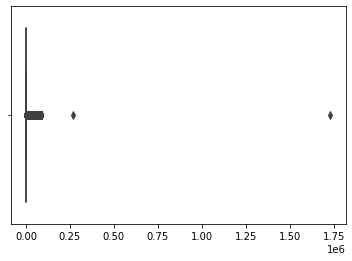

In [20]:
sns.boxplot(x = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds())

### EDA passengger count

<AxesSubplot:ylabel='Frequency'>

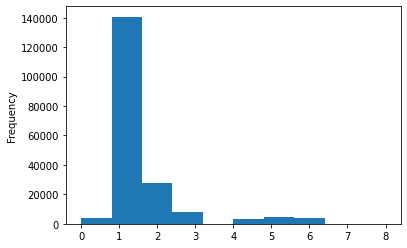

In [21]:
data['passenger_count'].plot.hist()

<AxesSubplot:xlabel='passenger_count'>

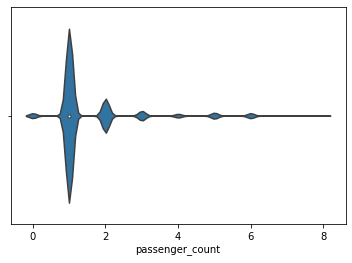

In [22]:
sns.violinplot(x=data['passenger_count'])

most record show that 1 person ride are the common(imputatation candidate)  
but weirdly enough there is zero passengger(sending goods? or there is some person with enormous goods and need a second taxi for the goods?)    

### EDA trip distance

In [23]:
data['trip_distance'].describe()

count    204648.000000
mean          4.928940
std         305.324989
min           0.000000
25%           1.020000
50%           1.790000
75%           3.400000
max       84813.760000
Name: trip_distance, dtype: float64

<AxesSubplot:xlabel='trip_distance'>

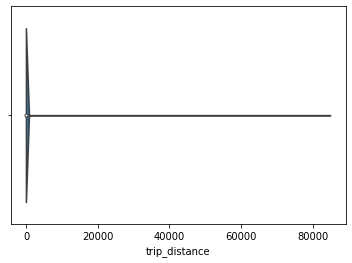

In [24]:
sns.violinplot(x=data['trip_distance'])

### EDA Rate Code ID

In [25]:
data['RatecodeID'].unique()

/home/andryw/.local/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[1.0, 2.0, 4.0, 5.0, 3.0, 99.0, NaN, 6.0]
Categories (7, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 99.0]

99 could be id for missing value

<AxesSubplot:>

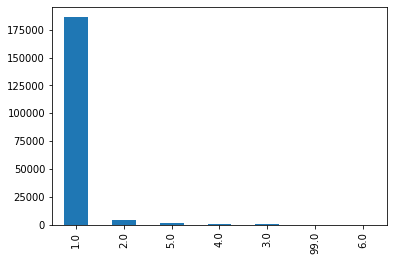

In [26]:
data['RatecodeID'].value_counts().plot.bar()

### EDA Location ID

In [27]:
PUID = data['PULocationID'].value_counts().sort_values()
DOID = data['DOLocationID'].value_counts().sort_values()

<AxesSubplot:>

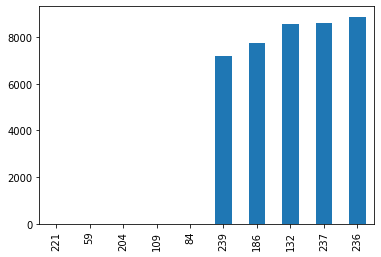

In [28]:
pd.concat([PUID[0:5],PUID[-5:]]).plot.bar()

<AxesSubplot:>

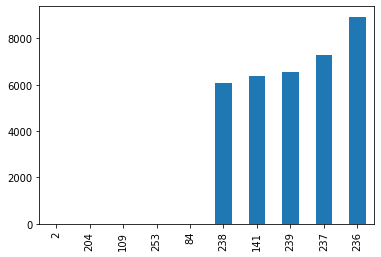

In [29]:
pd.concat([DOID[0:5],DOID[-5:]]).plot.bar()

In [30]:
data.groupby('PULocationID')['DOLocationID'].value_counts().sort_values()

PULocationID     
134           1         0
169           236       0
              230       0
              231       0
              232       0
                     ... 
239           238     853
264           264     911
236           236    1007
              237    1054
237           236    1284
Name: DOLocationID, Length: 67080, dtype: int64

In [31]:
data_list = data.groupby('PULocationID')['DOLocationID'].value_counts().sort_values()
data_list


PULocationID     
134           1         0
169           236       0
              230       0
              231       0
              232       0
                     ... 
239           238     853
264           264     911
236           236    1007
              237    1054
237           236    1284
Name: DOLocationID, Length: 67080, dtype: int64

In [32]:
data[(data['PULocationID']==134) & (data['DOLocationID']==1)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,store_fwd__N,store_fwd__Y


In [33]:
for idxdata,ndata in data_list.iteritems():
    print(idxdata,ndata)

(134, 1) 0
(169, 236) 0
(169, 230) 0
(169, 231) 0
(169, 232) 0
(169, 233) 0
(169, 216) 0
(169, 214) 0
(169, 193) 0
(169, 212) 0
(169, 194) 0
(169, 196) 0
(169, 237) 0
(169, 197) 0
(169, 200) 0
(169, 201) 0
(169, 202) 0
(169, 203) 0
(169, 251) 0
(169, 204) 0
(169, 205) 0
(169, 249) 0
(169, 206) 0
(169, 207) 0
(169, 248) 0
(169, 198) 0
(169, 229) 0
(169, 228) 0
(169, 227) 0
(169, 161) 0
(169, 162) 0
(169, 163) 0
(169, 164) 0
(169, 165) 0
(169, 166) 0
(169, 167) 0
(169, 260) 0
(169, 258) 0
(169, 191) 0
(169, 195) 0
(169, 192) 0
(169, 215) 0
(169, 217) 0
(169, 241) 0
(169, 218) 0
(169, 240) 0
(169, 220) 0
(169, 221) 0
(169, 222) 0
(169, 223) 0
(169, 239) 0
(169, 225) 0
(169, 226) 0
(169, 238) 0
(169, 209) 0
(169, 160) 0
(169, 147) 0
(169, 211) 0
(169, 67) 0
(169, 70) 0
(169, 71) 0
(169, 34) 0
(169, 33) 0
(169, 31) 0
(169, 30) 0
(169, 4) 0
(169, 5) 0
(169, 6) 0
(169, 7) 0
(169, 66) 0
(169, 8) 0
(169, 10) 0
(169, 11) 0
(169, 12) 0
(169, 13) 0
(169, 14) 0
(169, 15) 0
(169, 16) 0
(169, 17) 0
(

In [34]:
data_list.index[0][0]

134

2 seed better
16 looks good too

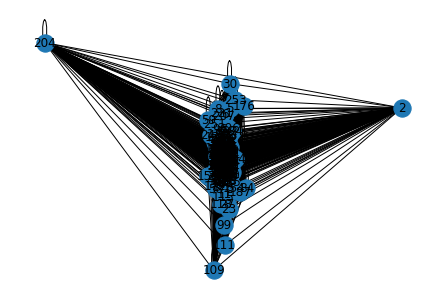

In [35]:
new_G = nx.Graph()
[new_G.add_edge(idxdata[0], idxdata[1], weight=ndata) for idxdata, ndata in data_list.iteritems()]
pos = nx.spring_layout(new_G,seed = 16)
# nx.draw_networkx_labels(new_G, pos, font_size=20, font_family="sans-serif")
nx.draw(new_G, pos, with_labels=True)

### payment type

<AxesSubplot:>

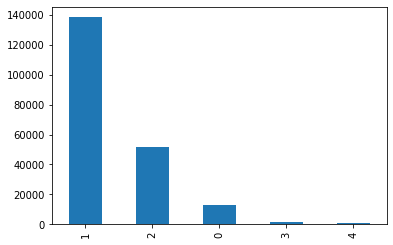

In [36]:
data['payment_type'].value_counts().plot.bar()

In [37]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,3,204648,204648
tpep_pickup_datetime,datetime64[ns],0,151505,204648,204648
tpep_dropoff_datetime,datetime64[ns],0,151433,204648,204648
passenger_count,float64,12694,8,191954,204648
trip_distance,float64,0,2800,204648,204648
RatecodeID,category,12694,7,191954,204648
store_and_fwd_flag,object,12694,2,191954,204648
PULocationID,category,0,248,204648,204648
DOLocationID,category,0,258,204648,204648
payment_type,category,0,5,204648,204648


### Payment EDA
<a id='Payment-EDA'></a>
1. $2.50 initial charge.
2. Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
3. Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
4. Plus 30 cents Improvement Surcharge.
5. Plus 50 cents overnight surcharge 8pm to 6am.
6. Plus $1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
7. Plus New York State Congestion Surcharge of $2.50 (Yellow Taxi) or $2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
8. Plus tips and any tolls.
9. There is no charge for extra passengers, luggage or bags, or paying by credit card.
10. The on-screen rate message should read: "Rate #01 – Standard City Rate."
11. Make sure to always take your receipt.  


data field and the rule  
fare_amount             = 1,2  
extra                   = 3,5,6(depends on the ratecode id)  
mta_tax                 = tax(in data -0.5, 0, 0.5)  
tip_amount              = 8  
tolls_amount            = 8  
improvement_surcharge   = 4  
total_amount            = (total payment)  
congestion_surcharge    = 7  

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

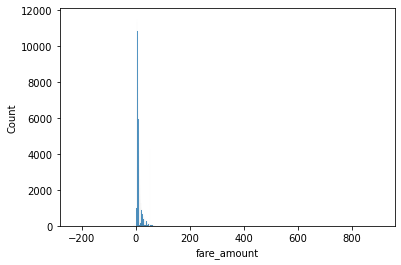

In [38]:
sns.histplot(data['fare_amount'])

the value of the fare amount can be below 0, might be invalid data

<AxesSubplot:>

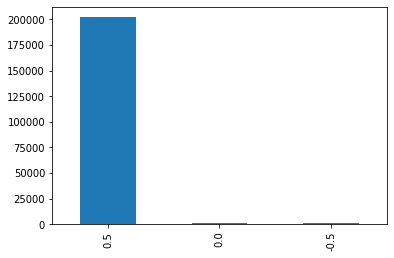

In [39]:
data['mta_tax'].value_counts().plot.bar()

minus data again could be invalid

<AxesSubplot:ylabel='Density'>

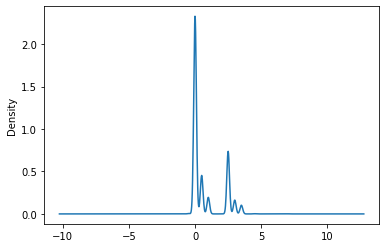

In [40]:
data['extra'].plot.kde()

In [41]:
data['extra'].value_counts()

 0.00    119479
 2.50     37812
 0.50     23237
 1.00     10009
 3.00      8337
 3.50      5252
-0.50       254
 4.50       122
 7.00        73
-1.00        57
 0.80         4
 5.10         1
 2.30         1
-4.50         1
 4.77         1
 1.42         1
 1.06         1
 1.88         1
 1.81         1
 2.08         1
 1.57         1
 1.95         1
 1.07         1
Name: extra, dtype: int64

minus data and most data between 0 and 5

<AxesSubplot:ylabel='Density'>

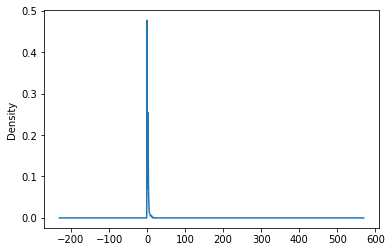

In [42]:
data['tip_amount'].plot.kde()

tip amount could be very big or minus. mostly doesn't give tip

<AxesSubplot:ylabel='Density'>

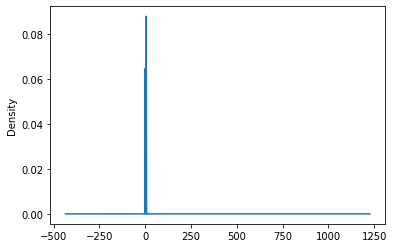

In [43]:
data['tolls_amount'].plot.kde()

mostly not go through toll. but there is some weird value like minus and super high number

<AxesSubplot:>

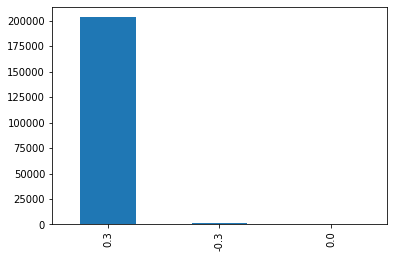

In [44]:
data['improvement_surcharge'].value_counts().plot.bar()

based on [fare website](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page#:~:text=%242.50%20initial%20charge.,Dutchess%2C%20Orange%20or%20Putnam%20Counties.)  
Plus 30 cents Improvement Surcharge.

but in the data there is -0.3 improvement surcharge

<AxesSubplot:ylabel='Density'>

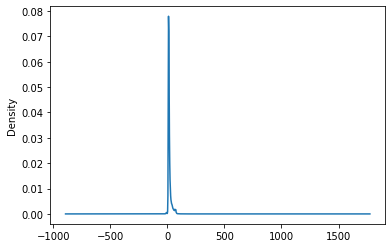

In [45]:
data['total_amount'].plot.kde()

minus total fare, how could this happen?

<AxesSubplot:>

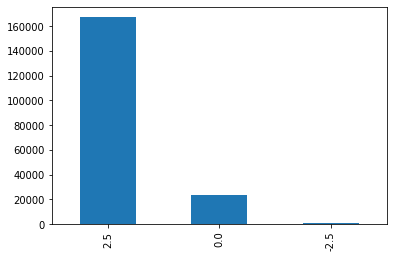

In [46]:
data['congestion_surcharge'].value_counts().plot.bar()

congestion surchage minus it might be anomaly  
airport_fee all missing value so this column will be removed for this process

In [47]:
data = data.drop('airport_fee',axis=1)

In [48]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,3,204648,204648
tpep_pickup_datetime,datetime64[ns],0,151505,204648,204648
tpep_dropoff_datetime,datetime64[ns],0,151433,204648,204648
passenger_count,float64,12694,8,191954,204648
trip_distance,float64,0,2800,204648,204648
RatecodeID,category,12694,7,191954,204648
store_and_fwd_flag,object,12694,2,191954,204648
PULocationID,category,0,248,204648,204648
DOLocationID,category,0,258,204648,204648
payment_type,category,0,5,204648,204648


<AxesSubplot:xlabel='passenger_count,None'>

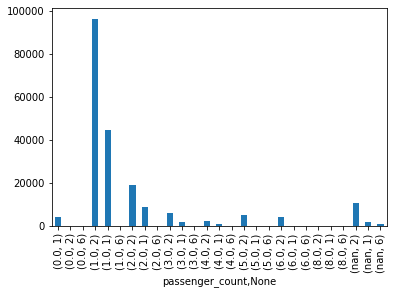

In [49]:
data.groupby('passenger_count', dropna=False)['VendorID'].value_counts().plot.bar()

In [50]:
data['trip_time'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds()

In [51]:
data['payment_type'].unique()

[2, 1, 4, 3, 0]
Categories (5, int64): [0, 1, 2, 3, 4]

In [52]:
data[['trip_time','payment_type']].groupby('payment_type').describe()

trip_time                                                 \
                 count         mean          std  min     25%     50%   
payment_type                                                            
0              12694.0  1299.452025   894.087646  0.0  635.25  1080.0   
1             138196.0   822.221794  3688.174298  0.0  323.00   521.0   
2              51397.0   917.325739  8886.230241  0.0  289.00   496.0   
3               1354.0   545.318316  2350.820760  0.0   78.00   262.0   
4               1007.0   647.903674  2760.811452  2.0  132.50   371.0   

                                  
                  75%        max  
payment_type                      
0             1740.00     7203.0  
1              839.00    86398.0  
2              839.00  1729062.0  
3              700.25    84191.0  
4              806.00    86103.0

In [53]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,3,204648,204648
tpep_pickup_datetime,datetime64[ns],0,151505,204648,204648
tpep_dropoff_datetime,datetime64[ns],0,151433,204648,204648
passenger_count,float64,12694,8,191954,204648
trip_distance,float64,0,2800,204648,204648
RatecodeID,category,12694,7,191954,204648
store_and_fwd_flag,object,12694,2,191954,204648
PULocationID,category,0,248,204648,204648
DOLocationID,category,0,258,204648,204648
payment_type,category,0,5,204648,204648


In [54]:
describe_data(data[data['payment_type']==0])

,0,Miss,Unique,Count,Total
VendorID,category,0,3,12694,12694
tpep_pickup_datetime,datetime64[ns],0,10244,12694,12694
tpep_dropoff_datetime,datetime64[ns],0,9995,12694,12694
passenger_count,float64,12694,0,0,12694
trip_distance,float64,0,2235,12694,12694
RatecodeID,category,12694,0,0,12694
store_and_fwd_flag,object,12694,0,0,12694
PULocationID,category,0,240,12694,12694
DOLocationID,category,0,252,12694,12694
payment_type,category,0,1,12694,12694


In [55]:
data[data['payment_type']==0].store_fwd__N.unique()

<BooleanArray>
[False]
Length: 1, dtype: boolean

In [56]:
data[data['payment_type']==0].store_fwd__Y.unique()

<BooleanArray>
[False]
Length: 1, dtype: boolean

In [57]:
data[data['payment_type']!=0].store_fwd__Y.unique()

<BooleanArray>
[False, True]
Length: 2, dtype: boolean

In [58]:
data[data['payment_type']!=0].store_fwd__N.unique()

<BooleanArray>
[True, False]
Length: 2, dtype: boolean

All missing value observed only occured in payment_type 0
store_fwd data also both False it mean data missing

payment_type
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

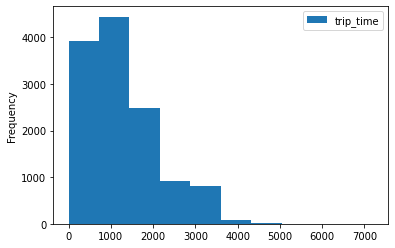

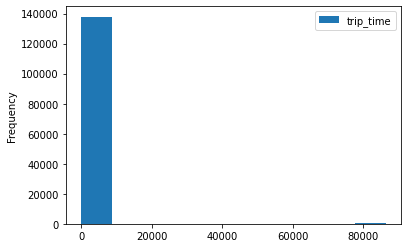

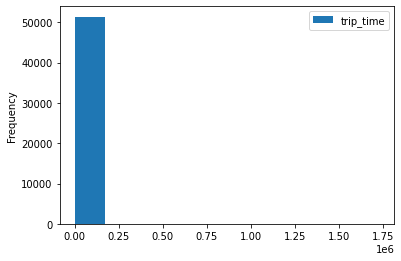

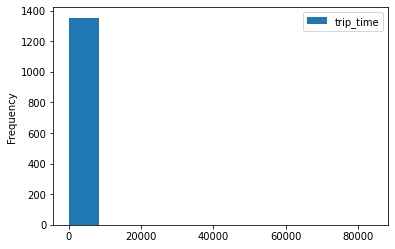

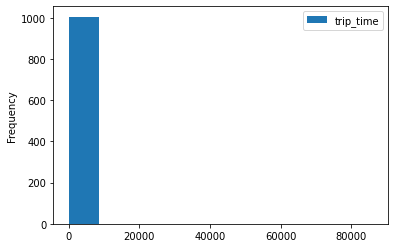

In [59]:
data[['trip_time','payment_type']].groupby('payment_type').plot.hist()

In [60]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,3,204648,204648
tpep_pickup_datetime,datetime64[ns],0,151505,204648,204648
tpep_dropoff_datetime,datetime64[ns],0,151433,204648,204648
passenger_count,float64,12694,8,191954,204648
trip_distance,float64,0,2800,204648,204648
RatecodeID,category,12694,7,191954,204648
store_and_fwd_flag,object,12694,2,191954,204648
PULocationID,category,0,248,204648,204648
DOLocationID,category,0,258,204648,204648
payment_type,category,0,5,204648,204648


<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

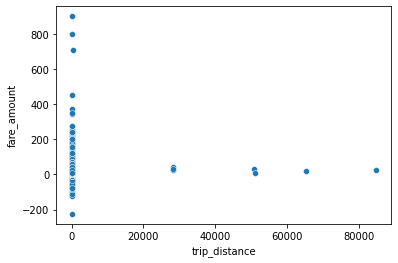

In [61]:
sns.scatterplot(data=data, x='trip_distance',y='fare_amount')

<AxesSubplot:xlabel='trip_distance', ylabel='fare_amount'>

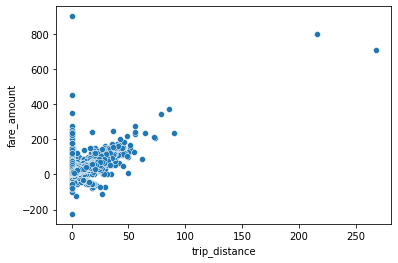

In [62]:
data_min=data[data['trip_distance']<20000]
sns.scatterplot(data=data_min, x='trip_distance',y='fare_amount')

there is some fare that doesnt make sense[how to calculate fare ](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page#:~:text=%242.50%20initial%20charge.,Dutchess%2C%20Orange%20or%20Putnam%20Counties.):
1. trip distance too long but price look the same
2. trip distance near 0 but cost difference

<AxesSubplot:xlabel='total_amount', ylabel='fare_amount'>

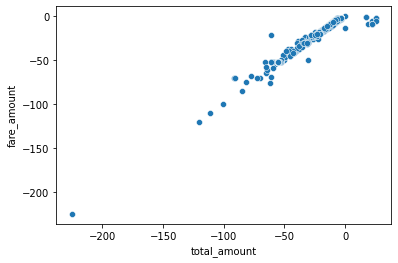

In [63]:
data_min=data[data['fare_amount']<0]
sns.scatterplot(data=data_min, x='total_amount',y='fare_amount')

In [64]:
data_min['total_amount'].describe()

count    1158.000000
mean      -14.160371
std        16.299746
min      -225.300000
25%       -13.800000
50%        -8.800000
75%        -6.800000
max        25.500000
Name: total_amount, dtype: float64

In [65]:
pd.crosstab(data['RatecodeID'],data['payment_type'])

payment_type,1,2,3,4
RatecodeID,,,,
1.0,133485,50399,1262,934
2.0,3514,669,29,30
3.0,116,70,4,10
4.0,133,84,3,4
5.0,947,171,55,29
6.0,0,1,1,0
99.0,1,3,0,0


In [66]:
chi2, p, dof, expected = chi2_contingency(pd.crosstab(data['RatecodeID'],data['payment_type']))

In [67]:
chi2,p,dof,expected

(881.0942016068071,
 1.6872670249638691e-175,
 18,
 array([[1.33967053e+05, 4.98241962e+04, 1.31256614e+03, 9.76184711e+02],
        [3.05399956e+03, 1.13582459e+03, 2.99221063e+01, 2.22537379e+01],
        [1.43988664e+02, 5.35513717e+01, 1.41075466e+00, 1.04920971e+00],
        [1.61267304e+02, 5.99775363e+01, 1.58004522e+00, 1.17511487e+00],
        [8.65371870e+02, 3.21843744e+02, 8.47863551e+00, 6.30575034e+00],
        [1.43988664e+00, 5.35513717e-01, 1.41075466e-02, 1.04920971e-02],
        [2.87977328e+00, 1.07102743e+00, 2.82150932e-02, 2.09841941e-02]]))

In [68]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,3,204648,204648
tpep_pickup_datetime,datetime64[ns],0,151505,204648,204648
tpep_dropoff_datetime,datetime64[ns],0,151433,204648,204648
passenger_count,float64,12694,8,191954,204648
trip_distance,float64,0,2800,204648,204648
RatecodeID,category,12694,7,191954,204648
store_and_fwd_flag,object,12694,2,191954,204648
PULocationID,category,0,248,204648,204648
DOLocationID,category,0,258,204648,204648
payment_type,category,0,5,204648,204648


In [69]:
describe_data(data[data['passenger_count'].isna()])

,0,Miss,Unique,Count,Total
VendorID,category,0,3,12694,12694
tpep_pickup_datetime,datetime64[ns],0,10244,12694,12694
tpep_dropoff_datetime,datetime64[ns],0,9995,12694,12694
passenger_count,float64,12694,0,0,12694
trip_distance,float64,0,2235,12694,12694
RatecodeID,category,12694,0,0,12694
store_and_fwd_flag,object,12694,0,0,12694
PULocationID,category,0,240,12694,12694
DOLocationID,category,0,252,12694,12694
payment_type,category,0,1,12694,12694


In [70]:
data[data['passenger_count'].isna()].payment_type.unique()

[0]
Categories (5, int64): [0, 1, 2, 3, 4]

In [71]:
describe_data(data[data['payment_type'] == 0])

,0,Miss,Unique,Count,Total
VendorID,category,0,3,12694,12694
tpep_pickup_datetime,datetime64[ns],0,10244,12694,12694
tpep_dropoff_datetime,datetime64[ns],0,9995,12694,12694
passenger_count,float64,12694,0,0,12694
trip_distance,float64,0,2235,12694,12694
RatecodeID,category,12694,0,0,12694
store_and_fwd_flag,object,12694,0,0,12694
PULocationID,category,0,240,12694,12694
DOLocationID,category,0,252,12694,12694
payment_type,category,0,1,12694,12694


since payment type 0 is unknown even in the data dictionary, drop this record might be best decision for now  
maybe we could comeback to find out is there any pattern in it  


In [72]:
data = data[data['payment_type'] != 0]
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,2,191954,191954
tpep_pickup_datetime,datetime64[ns],0,145262,191954,191954
tpep_dropoff_datetime,datetime64[ns],0,145369,191954,191954
passenger_count,float64,0,8,191954,191954
trip_distance,float64,0,2670,191954,191954
RatecodeID,category,0,7,191954,191954
store_and_fwd_flag,object,0,2,191954,191954
PULocationID,category,0,239,191954,191954
DOLocationID,category,0,256,191954,191954
payment_type,category,0,4,191954,191954


In [73]:
data['total_amount'].sort_values()

140989    -225.30
79178     -120.30
82775     -111.30
1793      -100.30
60183      -91.39
           ...   
85557      450.30
96194      815.05
61870      832.54
196595     900.35
64136     1108.20
Name: total_amount, Length: 191954, dtype: float64

since there is no explanation why this number could be negative, i will drop it  
negative amount could be trip that not paid or free ride  
as mentioned in [Payment EDA](#Payment-EDA)  

fare_amount             = 2.5 and up  
extra                   = 3,5,6(unknown minimum value)    
mta_tax                 = tax(in data -0.5, 0, 0.5)    
tip_amount              = depends on the one giving tips   
tolls_amount            = depends on the tolls   
improvement_surcharge   = 0.3 but some data show 0 could be there is condition to apply this    
total_amount            = (total payment)    
congestion_surcharge    = 2.5 or 0  

lets remove all data that not follow above rule  

In [74]:
data[data['fare_amount']>0]['fare_amount'].describe()

count    190713.000000
mean         12.155361
std          12.151360
min           0.010000
25%           6.000000
50%           8.500000
75%          13.000000
max         900.000000
Name: fare_amount, dtype: float64

In [75]:
data = data[data['fare_amount']>=2.5]
data = data[data['mta_tax']>=0]
data = data[data['improvement_surcharge']>=0]
data = data[data['congestion_surcharge']>=0]

In [76]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,2,190669,190669
tpep_pickup_datetime,datetime64[ns],0,145169,190669,190669
tpep_dropoff_datetime,datetime64[ns],0,145285,190669,190669
passenger_count,float64,0,8,190669,190669
trip_distance,float64,0,2670,190669,190669
RatecodeID,category,0,7,190669,190669
store_and_fwd_flag,object,0,2,190669,190669
PULocationID,category,0,239,190669,190669
DOLocationID,category,0,256,190669,190669
payment_type,category,0,4,190669,190669


from trip time and trip distance we could find there is some outlier  
but it could be normal and lets find those outlier and find out if any of the data is valid with their   
drop all row with 0 trip time and trip distance(too much effort to imputing)     

In [77]:
data = data[(data['trip_time']!=0) & (data['trip_distance']!=0)]

we have 2 rule fare amount, lets find out range possible price for the data and remove any data that shouldnt be possible
1. $2.50 initial charge.
2. Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.  
  
worst case scenario         : (0.5 * 5 * fare_distance) + (0.5 * (fare_time/60))    
12mph = 12 / 3600 mps   
speed_trip = fare_distance/fare_time    
best/average case scenario  : {    
    speed_trip < 12 mph     : 0.5 * 5 * fare_distance + (0.5 *((fare_time - (fare_distance*3600/12))/60))  
    speed_trip >= 12 mph    : 0.5 * 5 * fare_distance  
}    

In [78]:
def price_scenario(row :pd.DataFrame)-> tuple[float,float]:
    worst = (0.5 * 5 * row['trip_distance']) + (0.5 * (row['trip_time']/60))
    if((row['trip_distance']/row['trip_time']) >= (12 / 3600)):
        best = 0.5 * 5 * row['trip_distance']
    else:
        best = 0.5 * 5 * row['trip_distance'] + (0.5 *((row['trip_time'] - (row['trip_distance']*3600/12))/60)) 
    return worst,best


In [79]:
drop_num = []
for idx, rows in  data.iterrows():
    worst, best = price_scenario(rows)
    if((rows['fare_amount']<best) or (rows['fare_amount'] > worst)):
        drop_num.append(idx)

data.drop(index = drop_num)
# print(drop_num)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,...,3.0,0.5,0.00,0.0,0.3,11.80,2.5,True,False,362.0
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,...,0.5,0.5,8.65,0.0,0.3,51.95,0.0,True,False,1656.0
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,...,0.5,0.5,6.05,0.0,0.3,36.35,0.0,True,False,913.0
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,...,0.5,0.5,4.06,0.0,0.3,24.36,2.5,True,False,992.0
5,1,2021-01-01 00:16:29,2021-01-01 00:24:30,1.0,1.60,1.0,N,224,68,1,...,3.0,0.5,2.35,0.0,0.3,14.15,2.5,True,False,481.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203016,2,2021-01-10 23:47:41,2021-01-11 00:02:41,1.0,5.60,1.0,N,48,82,2,...,0.5,0.5,0.00,0.0,0.3,21.30,2.5,True,False,900.0
203018,2,2021-01-10 23:47:49,2021-01-11 00:00:17,1.0,7.70,1.0,N,138,80,1,...,0.5,0.5,4.00,0.0,0.3,27.30,0.0,True,False,748.0
203019,2,2021-01-10 23:59:26,2021-01-11 00:12:57,2.0,7.54,1.0,N,70,255,1,...,0.5,0.5,4.76,0.0,0.3,28.56,0.0,True,False,811.0
203020,2,2021-01-10 23:52:33,2021-01-11 00:17:25,1.0,16.61,2.0,N,132,237,1,...,0.0,0.5,7.00,0.0,0.3,62.30,2.5,True,False,1492.0


data that not in normal range are deleted

In [80]:
describe_data(data)

,0,Miss,Unique,Count,Total
VendorID,category,0,2,188001,188001
tpep_pickup_datetime,datetime64[ns],0,143565,188001,188001
tpep_dropoff_datetime,datetime64[ns],0,143652,188001,188001
passenger_count,float64,0,7,188001,188001
trip_distance,float64,0,2669,188001,188001
RatecodeID,category,0,7,188001,188001
store_and_fwd_flag,object,0,2,188001,188001
PULocationID,category,0,228,188001,188001
DOLocationID,category,0,256,188001,188001
payment_type,category,0,4,188001,188001


In [81]:
time_description = data['trip_time'].describe()
time_description

count    1.880010e+05
mean     8.456429e+02
std      5.571539e+03
min      1.000000e+00
25%      3.170000e+02
50%      5.160000e+02
75%      8.370000e+02
max      1.729062e+06
Name: trip_time, dtype: float64

In [82]:
dist_description = data['trip_distance'].describe()
dist_description

count    188001.000000
mean          3.103106
std           4.101401
min           0.010000
25%           1.030000
50%           1.740000
75%           3.180000
max         267.700000
Name: trip_distance, dtype: float64

/home/andryw/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='trip_time', ylabel='trip_distance'>

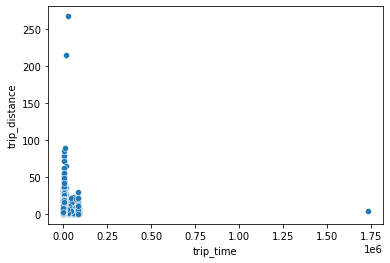

In [83]:
sns.scatterplot(data['trip_time'],data['trip_distance'])

In [84]:
IQR_time = time_description['75%'] - time_description['25%']
upper_bound_time = time_description['75%']+(1.5*IQR_time)
lower_bound_time = time_description['25%']-(1.5*IQR_time)

In [85]:
IQR_dist = dist_description['75%'] - dist_description['25%']
upper_bound_dist = dist_description['75%']+(1.5*IQR_dist)
lower_bound_dist = dist_description['25%']-(1.5*IQR_dist)

In [86]:
data[data['trip_time']<=lower_bound_time]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time


In [87]:
data[data['trip_distance']<=lower_bound_dist]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time


In [88]:
data[data['trip_time']>=upper_bound_time]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,...,0.5,0.5,8.65,0.00,0.3,51.95,0.0,True,False,1656.0
24,1,2021-01-01 00:37:40,2021-01-01 01:04:46,2.0,19.10,1.0,N,132,3,2,...,0.5,0.5,0.00,6.12,0.3,59.42,0.0,True,False,1626.0
36,2,2021-01-01 00:55:13,2021-01-01 01:23:03,1.0,13.67,1.0,N,48,32,2,...,0.5,0.5,0.00,0.00,0.3,41.80,2.5,True,False,1670.0
119,2,2021-01-01 00:45:18,2021-01-01 01:15:13,1.0,6.71,1.0,N,230,82,2,...,0.5,0.5,0.00,0.00,0.3,28.30,2.5,True,False,1795.0
138,1,2021-01-01 00:16:58,2021-01-01 00:45:44,2.0,11.10,1.0,N,164,227,4,...,3.0,0.5,0.00,0.00,0.3,37.80,2.5,True,False,1726.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202948,2,2021-01-10 23:07:56,2021-01-10 23:53:40,1.0,20.96,5.0,N,137,137,2,...,0.0,0.5,0.00,0.00,0.3,123.30,2.5,True,False,2744.0
202952,1,2021-01-10 23:20:29,2021-01-10 23:47:32,1.0,17.20,2.0,N,132,164,1,...,2.5,0.5,5.58,6.12,0.3,67.00,2.5,True,False,1623.0
202954,1,2021-01-10 23:02:53,2021-01-10 23:35:40,1.0,19.30,2.0,N,132,239,1,...,2.5,0.5,4.00,0.00,0.3,59.30,2.5,True,False,1967.0
202974,2,2021-01-10 23:32:02,2021-01-11 00:10:24,1.0,19.43,1.0,N,35,115,1,...,0.5,0.5,2.75,12.24,0.3,70.79,0.0,True,False,2302.0


In [89]:
data[data['trip_distance']>=upper_bound_dist]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,...,0.5,0.5,8.65,0.00,0.3,51.95,0.0,True,False,1656.0
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,...,0.5,0.5,6.05,0.00,0.3,36.35,0.0,True,False,913.0
8,1,2021-01-01 00:39:16,2021-01-01 01:00:13,1.0,9.10,1.0,N,97,129,4,...,0.5,0.5,0.00,0.00,0.3,28.80,0.0,True,False,1257.0
12,1,2021-01-01 00:10:46,2021-01-01 00:32:58,2.0,7.40,1.0,N,138,166,2,...,2.5,0.5,0.00,6.12,0.3,33.92,0.0,True,False,1332.0
24,1,2021-01-01 00:37:40,2021-01-01 01:04:46,2.0,19.10,1.0,N,132,3,2,...,0.5,0.5,0.00,6.12,0.3,59.42,0.0,True,False,1626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203007,2,2021-01-10 23:19:47,2021-01-10 23:44:07,1.0,6.82,1.0,N,132,131,2,...,0.5,0.5,0.00,0.00,0.3,25.30,0.0,True,False,1460.0
203015,2,2021-01-10 23:53:38,2021-01-11 00:16:53,2.0,8.46,1.0,N,138,263,1,...,0.5,0.5,8.94,0.00,0.3,38.74,2.5,True,False,1395.0
203018,2,2021-01-10 23:47:49,2021-01-11 00:00:17,1.0,7.70,1.0,N,138,80,1,...,0.5,0.5,4.00,0.00,0.3,27.30,0.0,True,False,748.0
203019,2,2021-01-10 23:59:26,2021-01-11 00:12:57,2.0,7.54,1.0,N,70,255,1,...,0.5,0.5,4.76,0.00,0.3,28.56,0.0,True,False,811.0


In [90]:
data[data['trip_time']==0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time


In [91]:
data[data['trip_distance']==0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time


lets assume the taxi never stop and always in contast speed. based on the speed limit, max nyc speed limit are 50 mph. any data that faster than that will be dropped.  
what about data that have trip_time longer but trip_distance short?  
-   we will assume this taxi often stop, and based on taxi rule there is no limit for stopping.

In [92]:
data = data[data['trip_distance']*3600/data['trip_time'] <= 50]
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,store_fwd__N,store_fwd__Y,trip_time
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,...,3.0,0.5,0.00,0.0,0.3,11.80,2.5,True,False,362.0
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,...,0.5,0.5,0.00,0.0,0.3,4.30,0.0,True,False,59.0
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,...,0.5,0.5,8.65,0.0,0.3,51.95,0.0,True,False,1656.0
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,...,0.5,0.5,6.05,0.0,0.3,36.35,0.0,True,False,913.0
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,...,0.5,0.5,4.06,0.0,0.3,24.36,2.5,True,False,992.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203017,2,2021-01-10 23:59:39,2021-01-11 00:06:34,1.0,1.25,1.0,N,186,230,2,...,0.5,0.5,0.00,0.0,0.3,10.80,2.5,True,False,415.0
203018,2,2021-01-10 23:47:49,2021-01-11 00:00:17,1.0,7.70,1.0,N,138,80,1,...,0.5,0.5,4.00,0.0,0.3,27.30,0.0,True,False,748.0
203019,2,2021-01-10 23:59:26,2021-01-11 00:12:57,2.0,7.54,1.0,N,70,255,1,...,0.5,0.5,4.76,0.0,0.3,28.56,0.0,True,False,811.0
203020,2,2021-01-10 23:52:33,2021-01-11 00:17:25,1.0,16.61,2.0,N,132,237,1,...,0.0,0.5,7.00,0.0,0.3,62.30,2.5,True,False,1492.0


passenger count 0 still weird but lets assume this taxi only bring stuff

In [93]:
data = data[data['passenger_count']!=0]

In [94]:
data.to_csv('clean_data.csv')

In [95]:
dtneeded = data[['fare_amount','extra','mta_tax','improvement_surcharge','tip_amount','tolls_amount','total_amount','congestion_surcharge', 'tpep_pickup_datetime']].melt(
    id_vars=["tpep_pickup_datetime"], 
    var_name="Type_Amount", 
    value_name="Value")
dtneeded

,tpep_pickup_datetime,Type_Amount,Value
0,2021-01-01 00:30:10,fare_amount,8.0
1,2021-01-01 00:51:20,fare_amount,3.0
2,2021-01-01 00:43:30,fare_amount,42.0
3,2021-01-01 00:31:49,fare_amount,16.5
4,2021-01-01 00:16:29,fare_amount,8.0
...,...,...,...
1469819,2021-01-10 23:59:39,congestion_surcharge,2.5
1469820,2021-01-10 23:47:49,congestion_surcharge,0.0
1469821,2021-01-10 23:59:26,congestion_surcharge,0.0
1469822,2021-01-10 23:52:33,congestion_surcharge,2.5


In [96]:
dtneeded.to_csv('payment_breakdown_clean.csv')

In [97]:
data_counted = dtneeded.groupby([dtneeded['tpep_pickup_datetime'].dt.day,'Type_Amount']).sum()
data_counted.to_csv('payment_breakdown_summary.csv')